In [11]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 168MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 113MB/s]


In [122]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

In [149]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [150]:
class COVID19Dataset(Dataset):
    def __init__(self,path,mode='train',target_only=False):
        self.mode = mode
        with open(path,'r') as f:
            data = list(csv.reader(f))
            data = np.array(data[1:])[:, 1:].astype(np.float32)
            
        if not target_only:
            feats = list(range(93))
        else:
            feats = list(range(40)) + [57, 75]
        
        if mode == 'test':
            self.data = torch.FloatTensor(data[:, feats])
        else:
            target = data[:, -1]
            data = data[:, feats]

            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        #Normalize features
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [151]:
from random import shuffle


def prep_dataloader(path, mode, batch_size, n_jobs = 0, target_only=False):
    dataset = COVID19Dataset(path, mode, target_only=target_only)
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode == 'train'), drop_last=False, num_workers=n_jobs, pin_memory=True)
    return dataloader



In [152]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.criterion = nn.MSELoss(reduction='mean')
        # self.criterion = nn.L1Loss(reduction='mean')

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

In [153]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x,y in dv_set:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            loss = model.cal_loss(pred, y)
        total_loss += loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    return total_loss


In [154]:
def test(tt_test, model, device):
    model.eval()
    preds = []
    for x in tt_test:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

In [155]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    min_mse=1000.
    loss_record = {'train': [], 'dev': []}
    early_stop_count = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in tr_set:
            #优化器归零
            optimizer.zero_grad()
            #将特征和结果移动到对应的设备
            x,y = x.to(device), y.to(device)
            #前向传播
            pred = model(x)
            #计算损失
            mse_loss = model.cal_loss(pred, y)
            #反向传播
            mse_loss.backward()
            #更新参数
            optimizer.step()
            #损失结果移动到cpu便于记录
            loss_record['train'].append(mse_loss.detach().cpu().item())

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            #保存模型
            torch.save(model.state_dict(), config['save_path'])
            early_stop_count = 0
        else:
            early_stop_count += 1
        
        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_count > config['early_stop']:
            print('Early stopping!')
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [ ]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = True

config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 540,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.001              # momentum for SGD
    },
    'early_stop': 400,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [157]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 42)


In [158]:
model = NeuralNet(tr_set.dataset.dim).to(device)
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 321.2025)
Saving model (epoch =    2, loss = 314.8334)
Saving model (epoch =    3, loss = 308.6609)
Saving model (epoch =    4, loss = 302.6103)
Saving model (epoch =    5, loss = 296.5054)
Saving model (epoch =    6, loss = 290.0699)
Saving model (epoch =    7, loss = 283.1370)
Saving model (epoch =    8, loss = 275.4435)
Saving model (epoch =    9, loss = 266.5899)
Saving model (epoch =   10, loss = 255.9209)
Saving model (epoch =   11, loss = 242.5589)
Saving model (epoch =   12, loss = 224.4765)
Saving model (epoch =   13, loss = 197.4147)
Saving model (epoch =   14, loss = 150.0190)
Saving model (epoch =   15, loss = 63.2537)
Saving model (epoch =   16, loss = 15.5971)
Saving model (epoch =   17, loss = 7.3017)
Saving model (epoch =   18, loss = 5.1917)
Saving model (epoch =   19, loss = 4.4048)
Saving model (epoch =   20, loss = 3.9595)
Saving model (epoch =   21, loss = 3.6420)
Saving model (epoch =   22, loss = 3.3724)
Saving model (epoch =   

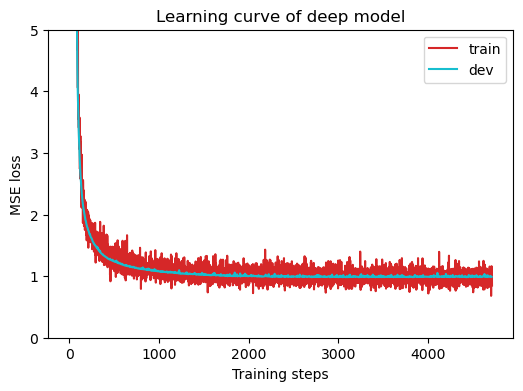

In [159]:
plot_learning_curve(model_loss_record, title='deep model')

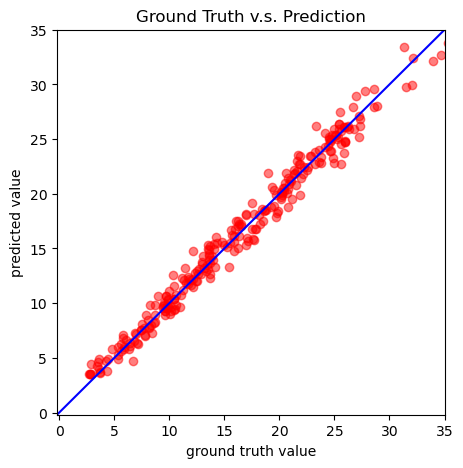

In [160]:
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [161]:
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'tested_positive'])
        for i,p in enumerate(preds):
            writer.writerow([i,p])

preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')



Saving results to pred.csv
